<a href="https://colab.research.google.com/github/LeticiaKang/HappyVirus/blob/Second-Main/Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.4 MB/s eta 0:00:00


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S,preprocess_input
from tensorflow.keras.applications.xception import Xception,preprocess_input
from tensorflow.keras.applications import MobileNetV3Small

from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
import tensorflow.keras.layers  as layers
from tensorflow.keras.optimizers import Adam
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from time import perf_counter, sleep

import tensorflow_addons as tfa


In [5]:
# Data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=120, 
                                   horizontal_flip = True,)
# width_shift_range=[-150, 150] 사진 자르기 ---- height_shift_range=[-150, 150] 높이 기준으로 자르기
# rotation_range=120 회전하기 ---- brightness_range=[0.1, 1.5] 색 바꾸기 0.1은 10%
# zoom_range=[0.3, 1.5] 확대 ---- shear_range=50 좌우 늘리기
print("start")

test_datagen = ImageDataGenerator(rescale = 1./255)

# Generate training and test sets
train_set = train_datagen.flow_from_directory(r'/content/drive/MyDrive/테스트용/train',
                                                #  target_size = (224,224),
                                                 target_size = (299,299),
                                                 batch_size = 16,
                                                #  batch_size = 128,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(r'/content/drive/MyDrive/테스트용/test',
                                            # target_size = (224,224),
                                            target_size = (299,299),
                                            batch_size = 16,
                                            # batch_size = 128,
                                            class_mode = 'categorical')

val_set = test_datagen.flow_from_directory(r'/content/drive/MyDrive/테스트용/val',
                                            # target_size = (224,224),
                                            target_size = (299,299),
                                            batch_size = 16,
                                            # batch_size = 128,
                                            class_mode = 'categorical')
print("end")

start
Found 221 images belonging to 8 classes.
Found 73 images belonging to 8 classes.
Found 73 images belonging to 8 classes.
end


In [9]:
# Load the InceptionResNetV2 model with pre-trained weights
input_tensor = tf.keras.layers.Input(shape=(299, 299, 3))
base_model = InceptionResNetV2(weights='imagenet', include_top=False,input_tensor=input_tensor)

# freezen the layers
for layer in base_model.layers[:-3]:
    layer.trainable = False

# Add a GlobalAveragePooling layer
x = base_model.output
x = layers.AveragePooling2D(pool_size = (7,7))(x)  # ★change
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
# fix a number of classes
predictions = Dense(8, activation='softmax')(x) # ★change

# compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(
              optimizer = Adam(), # ★change
              loss='categorical_crossentropy',
              metrics=['accuracy',
                          tf.keras.metrics.Precision(),
                          tf.keras.metrics.Recall(),
                          tfa.metrics. F1Score(num_classes = 8,
                                              average='macro')]
                )


In [10]:
# fit the model
start = perf_counter()
history = model.fit(train_set, epochs = 13, validation_data = val_set) # ★change # ★change # ★change
end = perf_counter()

# print the learning time
print(f"Time : {end-start}")

Epoch 1/13
14/14 [==============================] - 27s 1s/step - loss: 1.6288 - accuracy: 0.4525 - precision_1: 0.6061 - recall_1: 0.2715 - f1_score: 0.4674 - val_loss: 1.0517 - val_accuracy: 0.6986 - val_precision_1: 0.7667 - val_recall_1: 0.6301 - val_f1_score: 0.6920
Epoch 2/13
14/14 [==============================] - 13s 908ms/step - loss: 0.7157 - accuracy: 0.7466 - precision_1: 0.8497 - recall_1: 0.6652 - f1_score: 0.7423 - val_loss: 0.7913 - val_accuracy: 0.7534 - val_precision_1: 0.7846 - val_recall_1: 0.6986 - val_f1_score: 0.7443
Epoch 3/13
14/14 [==============================] - 12s 856ms/step - loss: 0.3475 - accuracy: 0.8824 - precision_1: 0.9485 - recall_1: 0.8326 - f1_score: 0.8804 - val_loss: 0.5659 - val_accuracy: 0.8493 - val_precision_1: 0.8939 - val_recall_1: 0.8082 - val_f1_score: 0.8452
Epoch 4/13
14/14 [==============================] - 12s 881ms/step - loss: 0.2697 - accuracy: 0.9186 - precision_1: 0.9505 - recall_1: 0.8688 - f1_score: 0.9196 - val_loss: 0.777

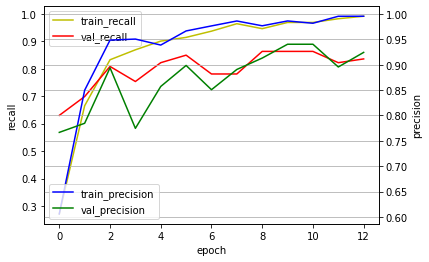

In [12]:
import matplotlib.pyplot as plt
fig, f1 = plt.subplots()

prec = f1.twinx()

f1.plot(history.history['recall_1'], 'y', label='train_recall')
f1.plot(history.history['val_recall_1'], 'r', label='val_recall')

prec.plot(history.history['precision_1'], 'b', label='train_precision')
prec.plot(history.history['val_precision_1'], 'g', label='val_precision')

f1.set_xlabel('epoch')
f1.set_ylabel('recall')
prec.set_ylabel('precision')

f1.legend(loc='upper left')
prec.legend(loc='lower left')

plt.grid()
plt.show()

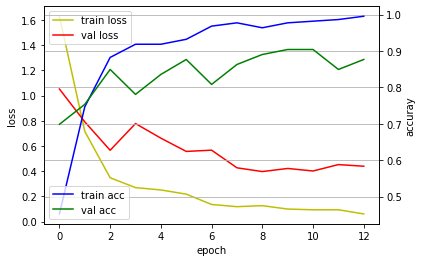

In [13]:
import matplotlib.pyplot as plt
fig, loss = plt.subplots()

acc = loss.twinx()

loss.plot(history.history['loss'], 'y', label='train loss')
loss.plot(history.history['val_loss'], 'r', label='val loss')

acc.plot(history.history['accuracy'], 'b', label='train acc')
acc.plot(history.history['val_accuracy'], 'g', label='val acc')

loss.set_xlabel('epoch')
loss.set_ylabel('loss')
acc.set_ylabel('accuray')

loss.legend(loc='upper left')
acc.legend(loc='lower left')

plt.grid()
plt.show()

In [14]:
# Evaluate the model on the test set
result= model.evaluate_generator(test_set) 

<ipython-input-14-e155823641e8>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  result= model.evaluate_generator(test_set)


In [15]:
print('loss:', round(result[0], 5))
print('accuracy:', round(result[1], 5))
print('precision:', round(result[2], 5))
print('recall:', round(result[3], 5))
print('f1-score:', round(result[4], 5))

loss: 0.25543
accuracy: 0.91781
precision: 0.95588
recall: 0.89041
f1-score: 0.91823


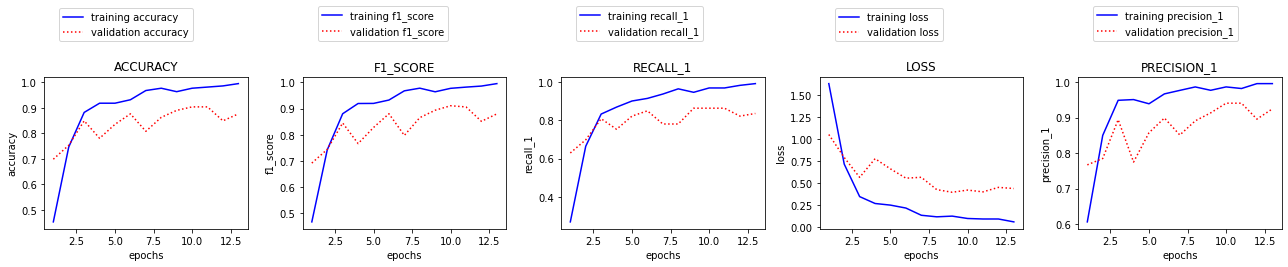

In [16]:
key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
plt.figure(figsize=(18, 4))
for idx , key in enumerate(key_value) :
    plt.subplot(1, len(key_value), idx+1)

    plt.title(f"{key.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{key.lower()}")
    value = history.history.get(key)
    val_value = history.history.get(f"val_{key}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {key}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {key}')
    plt.legend(loc='lower left', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)

plt.tight_layout()
plt.show()